# Analysis for MOT beam stabilization

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import os
import csv
results = 'C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\'

In [35]:
# from https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

## 2023.08.30

coil scan MOT powers

In [225]:
f = h5py.File(os.path.join(results, '2023-08-30\\14\\000004698-CoilScanSPCMCount.h5'))
[x for x in f['datasets'].values()]
MOTdata = [np.array(data) for data in  f['datasets'].values()][6:13]

In [229]:
directory=expdir = "C:\\Networking Experiment\\artiq codes\\artiq-master\\repository\\qn_artiq_routines\\analysis\\csv_data\\"
datafile = os.path.join(directory,"20230830_141518_coil_scan.csv")
t_exp = 0.3 # the SPCM exposure time in seconds. 


has_header = True
with open(datafile, 'r', newline='') as f:
    reader = csv.reader(f)
    if has_header:
        header = reader.__next__()
    data = [row for row in reader]#[:5]
    f.close()

data = np.array(data,float).transpose()
# print(data)
rows,cols = data.shape
counts = data[0]/t_exp # data is total counts in the exposure time. data/t_exp is the rate.

In [230]:
len(counts)

48400

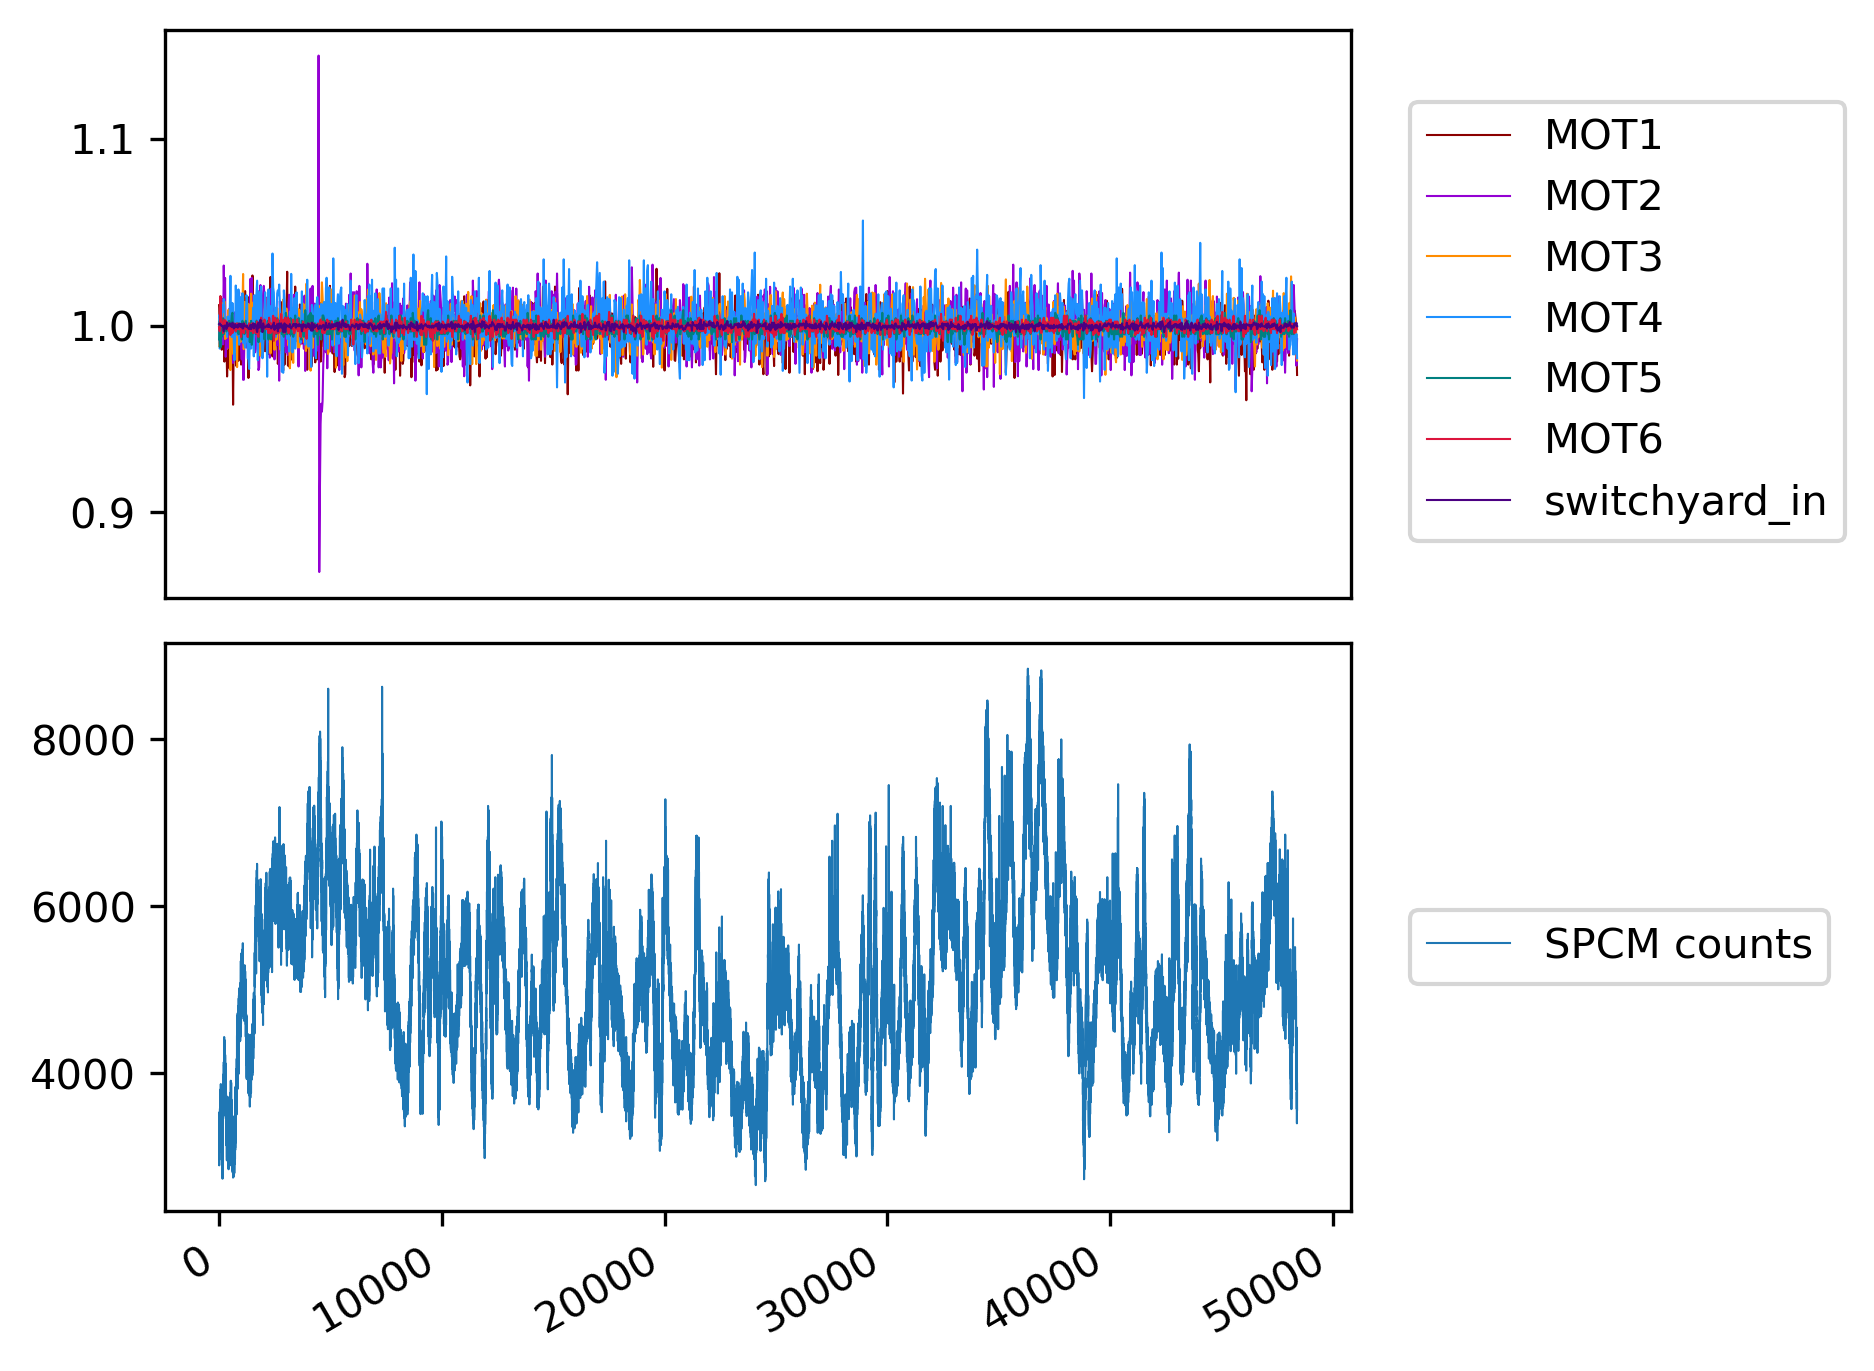

In [232]:
# the dip shown between about 30 and 500 is when I intentionally made the MOT go completely
# away by tuning the X shim, and then brought the MOT back to the same location "by hand".
# the duration of the experiment was about 10 minutes. every point showing the MOT power was
# plotted just after the feedback was run.

labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=2,dpi=300)
ax, ax2 = axes
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for label,data,color in zip(labels,MOTdata,colors):
    ypts = data[20:] # the feedback runs 20 times before we start counting photons
    xpts = range(len(ypts))
#     ax.scatter(xpts, ypts, color=color,s=0.1)
    ax.plot(xpts, ypts, color=color, label=label,linewidth=0.5)
#     ax.set_ylim((0.95,1.05))
    ax.legend(loc=(1.05,0.1))
ax.get_xaxis().set_visible(False)
ax2.plot(range(len(counts)),counts,label='SPCM counts',linewidth=0.5)
# ax2.set_xticks(timestamps)
plt.gcf().autofmt_xdate()
ax2.legend(loc=(1.05,0.4))
fig.tight_layout()

Last night I implemented averaging when measuring the signal for the AOM feedback, but removed the calls to measure 
background as I was not able to get both to work simultaneously.

Sometimes the  h5 file is not created when the experiment is terminated, but I haven't been able to detect the circumstances that lead to this. For data which is broadcast, I just plot all of it with an applet and then export the data to csv with the right click menu. This is not a good option, but for actual experiments, we will have a finite amount of time/number of iterations for which we run the experiment-- the h5 file not saving is almost certainly due to experiments which are ungracefully terminated.

In [16]:
data = []
with open('csv_data\\mot_powers_overnight_AOMsCoils_20230830.csv') as f:
    reader = csv.reader(f)
    header = reader.__next__()
    for row in reader:
        data.append([float(x) for x in row])

In [17]:
MOTdata_xy = np.array(data).transpose()

In [18]:
MOTdata_xy.shape

(14, 7285)

In [19]:
header

['MOT1_x',
 'MOT1_y',
 'MOT2_x',
 'MOT2_y',
 'MOT3_x',
 'MOT3_y',
 'MOT4_x',
 'MOT4_y',
 'MOT5_x',
 'MOT5_y',
 'MOT6_x',
 'MOT6_y',
 'MOT_switchyard_input_x',
 'MOT_switchyard_input_y']

In [27]:
[header[i] for i in range(len(MOTdata_xy)) if i%2]

['MOT1_y',
 'MOT2_y',
 'MOT3_y',
 'MOT4_y',
 'MOT5_y',
 'MOT6_y',
 'MOT_switchyard_input_y']

In [28]:
MOTdata = [MOTdata_xy[i] for i in range(len(MOTdata_xy)) if i%2]

Text(-0.03, 0.5, '$V_{\\rm PD}/V_{\\rm setpoint}$')

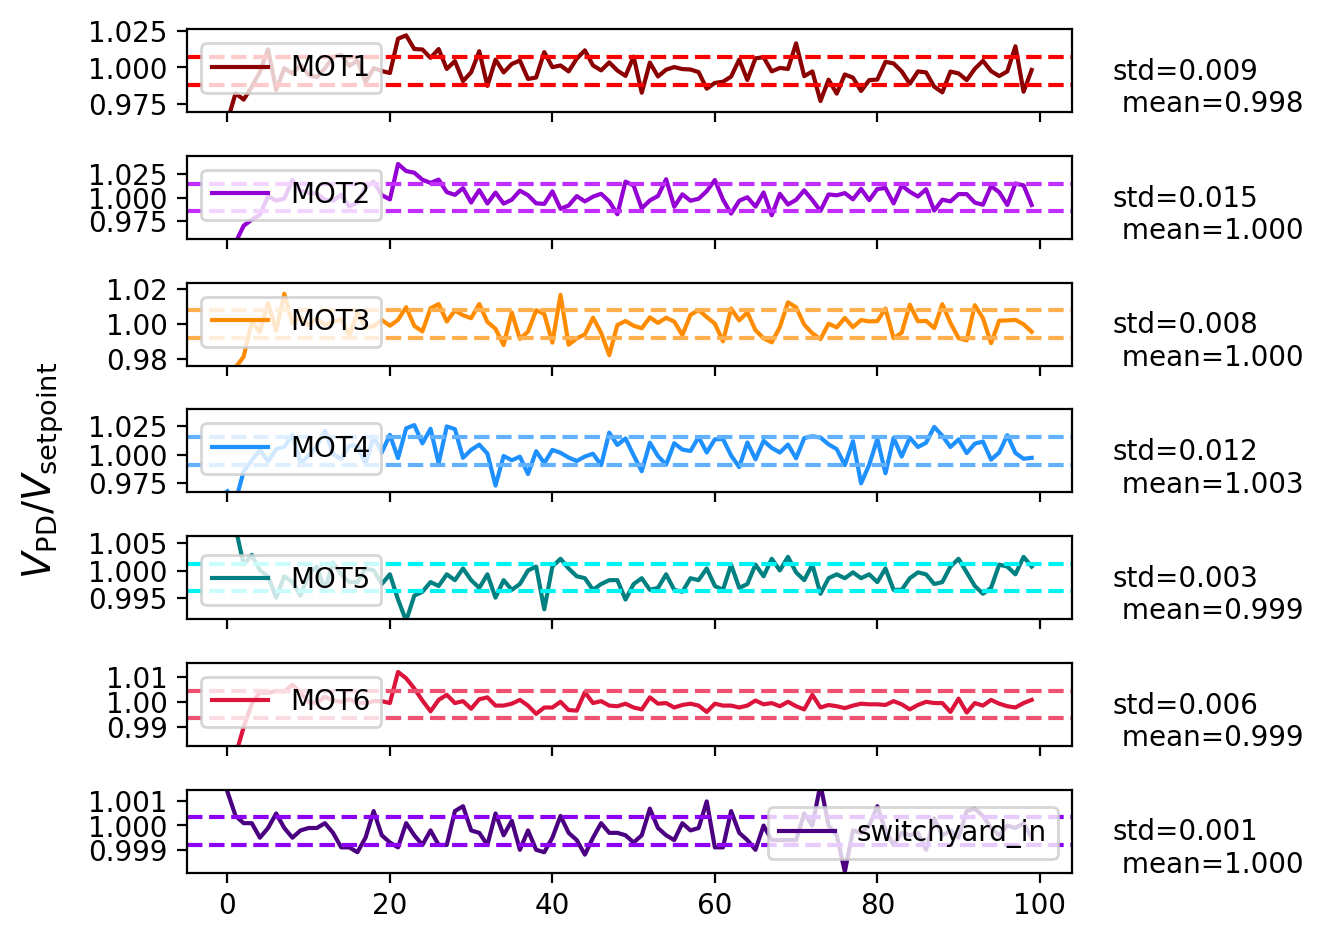

In [66]:
pts=100
labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=7,sharex=True,dpi=200)
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for ax,label,data,color in zip(axes,labels,MOTdata,colors):
    xpts = list(range(pts)) #len(data)-1))
    ypts =  data[1:1+pts]
    std = np.std(ypts)
    mean = np.mean(ypts)
    yrange = (mean-3*std, mean+3*std)
    ax.plot(xpts, ypts, label=label, color=color)
    ax.axhline(mean+std, linestyle='--', color=lighten_color(color,0.7))
    ax.axhline(mean-std, linestyle='--', color=lighten_color(color,0.7))
    ax.set_ylim(yrange) #(0.9,1.05))
    ax.text(max(xpts)+int(len(xpts)/10), min(yrange), f"std={std:.3f}\n mean={mean:.3f}", fontsize=10)
    ax.legend()
fig.tight_layout()
fig.text(-.03, 0.5, r'$V_{\rm PD}/V_{\rm setpoint}$', va='center', rotation='vertical',fontsize=14)

Text(0.45, -0.01, 'hours')

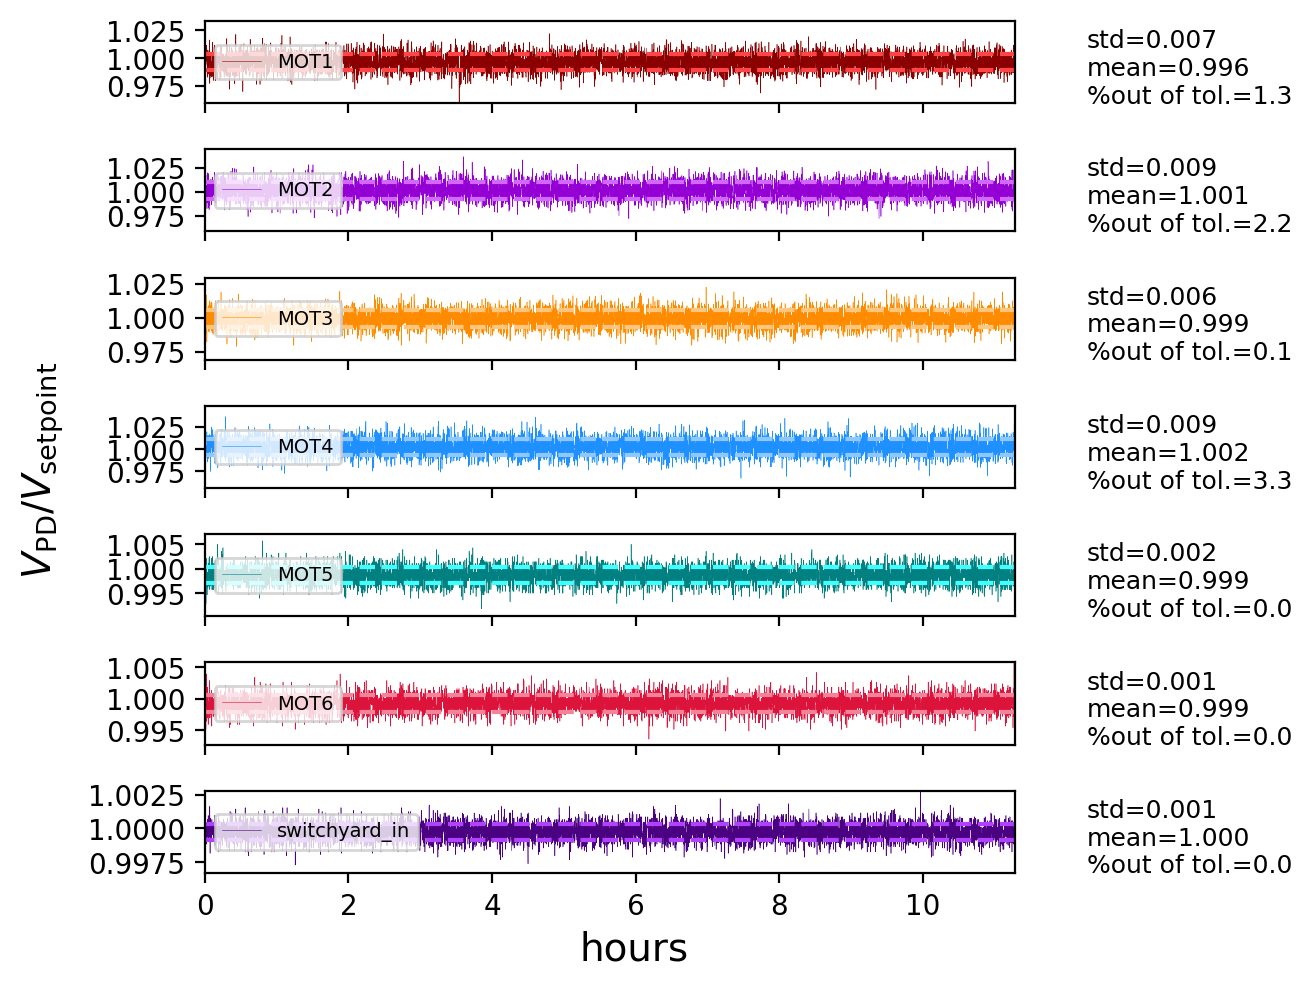

In [105]:
pts=-1
use_time = True
dt = 5.6 # seconds between measurments = time between running the feedback + duration of the feedback cycle
x_units = 3600 # hours
labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=7,sharex=True,dpi=200)
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for ax,label,data,color in zip(axes,labels,MOTdata,colors):
    ypts =  data[30:pts] # exclude the first several points where things are equilibrating
    n_pts = len(ypts)
    if use_time:
        xpts = np.linspace(0,5.6*n_pts/x_units,n_pts) 
    else:
        xpts = list(range(len(ypts)))
    std = np.std(ypts)
    mean = np.mean(ypts)
    yrange = (mean-5*std, mean+5*std)
#     maxdev = max((max(ypts)-mean, mean-min(ypts)))
    deviation = abs(ypts-1)
    maxdev = max(deviation)
    out_of_tol = len(deviation[deviation>0.02])/n_pts # fraction of points which were out of tolerance
    ax.plot(xpts, ypts, label=label, color=color,linewidth=0.2)
    ax.axhline(mean+std, linestyle='--', color=lighten_color(color,0.5))
    ax.axhline(mean-std, linestyle='--', color=lighten_color(color,0.5))
    ax.set_ylim(yrange) #(0.9,1.05))
    ax.set_xlim(min(xpts), max(xpts))
    ax.text(max(xpts)+int(max(xpts)/11), min(yrange), 
            f"std={std:.3f}\nmean={mean:.3f}\n%out of tol.={100*out_of_tol:.1f}",#"\nmax dev.={maxdev:.2f}", 
            fontsize=9)
    ax.legend(loc='center left',prop={'size': 7})
fig.tight_layout()
fig.text(-.03, 0.5, r'$V_{\rm PD}/V_{\rm setpoint}$', va='center', rotation='vertical',fontsize=14)
fig.text(0.45, -0.01, 'hours', ha='center',fontsize=14)

In [94]:
 maxdev = max((max(ypts)-mean, mean-min(ypts)))

In [95]:
maxdev

0.0029751831576136922

## 2023.08.28

I made a mistake which applies to the averaging vs no averaging tests below: the dds feedback was actually commented out. So all three datasets below are actually representative of the drift without feedback.

Using averaging in the measurement function gives the following result. There is no obvious deviation from using no averaging. This makes sense if there is also noise in the background.

In [ ]:
# self.measurement_array = np.full(8*self.num_samplers, 0.0)
# data_array = np.full(8, 0.0)
# for j in range(self.averages):
#     i = 0
#     for sampler in self.sampler_list:
#         sampler.sample(data_array)
#         self.measurement_array[i:i + 8] += data_array
#         delay(1 * ms)
#         i += 1
# self.measurement_array /= self.averages

In [21]:
f = h5py.File(os.path.join(results, '2023-08-28\\15\\000004481-AOMsCoils.h5'))
MOTdata = [np.array(data) for data in  f['datasets'].values()][6:13]

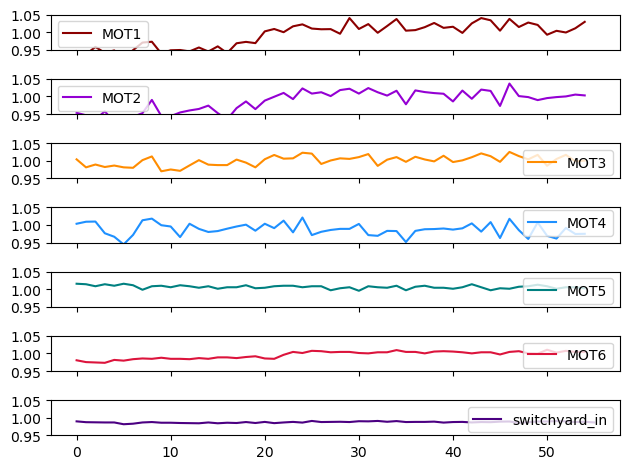

In [22]:
labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=7,sharex=True)
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for ax,label,data,color in zip(axes,labels,MOTdata,colors):
    xpts = list(range(len(data)-1))
    ax.plot(xpts, data[1:], label=label, color=color)
    ax.set_ylim((0.95,1.05))
    ax.legend()
fig.tight_layout()

Using averaging in the background function gives the following result. Right away, it is clear that this isn't working, as some beams deviate by ~ 20%, and others still go to 0.

In [ ]:
# self.background_array = np.full(8 * self.num_samplers, 0.0)
# data_array = np.full(8, 0.0)
# for j in range(self.averages):
#     i = 0
#     for sampler in self.sampler_list:
#         sampler.sample(data_array)
#         self.background_array[i:i + 8] += data_array
#         delay(1 * ms)
#         i += 1
# self.background_array /= self.averages

In [23]:
f = h5py.File(os.path.join(results, '2023-08-28\\15\\000004484-AOMsCoils.h5'))
MOTdata = [np.array(data) for data in  f['datasets'].values()][6:13]

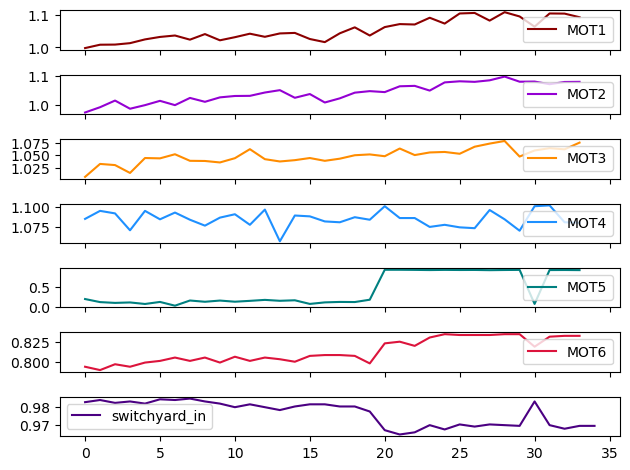

In [25]:
labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=7,sharex=True)
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for ax,label,data,color in zip(axes,labels,MOTdata,colors):
    xpts = list(range(len(data)-1))
    ax.plot(xpts, data[1:], label=label, color=color)
#     ax.set_ylim((0.95,1.05))
    ax.legend()
fig.tight_layout()

Using averaging in the neither gives the following result. It is clear that there is no  unexpected behavior, and that the data is quantitatively similar to the data from earlier today and last weekend.

In [31]:
f = h5py.File(os.path.join(results, '2023-08-28\\15\\000004489-AOMsCoils.h5'))
MOTdata = [np.array(data) for data in  f['datasets'].values()][6:13]

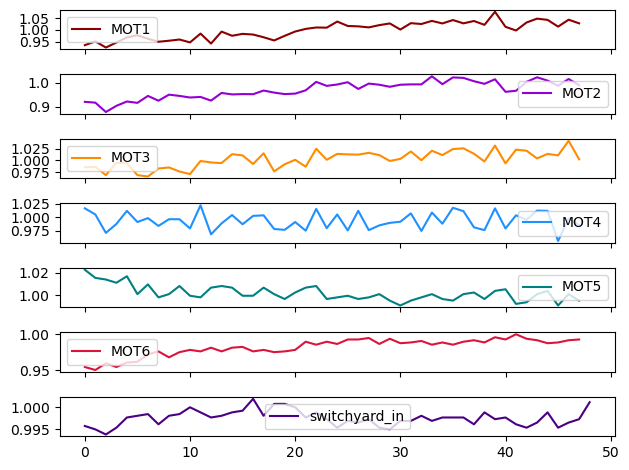

In [34]:
labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=7,sharex=True)
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for ax,label,data,color in zip(axes,labels,MOTdata,colors):
    xpts = list(range(len(data)-1))
    ax.plot(xpts, data[1:], label=label, color=color)
#     ax.set_ylim((0.95,1.05))
    ax.legend()
fig.tight_layout()

I don't see a MOT right now, and it may because of the behavior below in which MOT1,2 are way out of the desired tolerance.

In [10]:
# this is the data after I removed the 50 ms delay following turning off the series feedback channels, 
# so the currrent AOM is turned off and next AOM is turned on near simultaneously. These concurrent events
# are still followed by a 50 ms delay for the on-chip beams to allow for the detector rise time.
f = h5py.File(os.path.join(results, '2023-08-28\\10\\000004436-AOMsCoils.h5'))
MOTdata = [np.array(data) for data in  f['datasets'].values()][6:13]

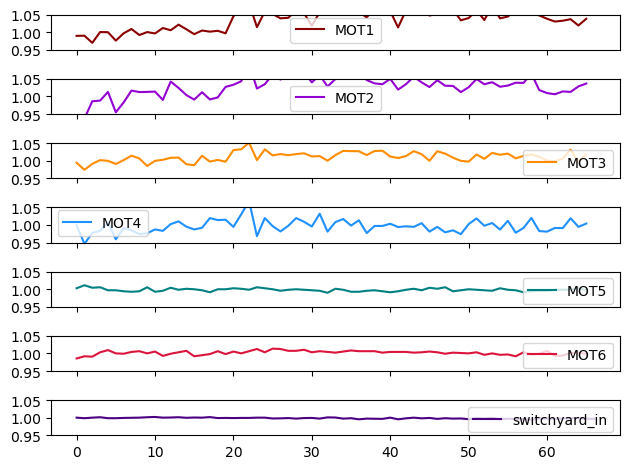

In [12]:
labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=7,sharex=True)
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for ax,label,data,color in zip(axes,labels,MOTdata,colors):
    xpts = list(range(len(data)-1))
    ax.plot(xpts, data[1:], label=label, color=color)
    ax.set_ylim((0.95,1.05))
    ax.legend()
fig.tight_layout()

In [17]:
# for comparison with the above data, I have put the delay back in between the turning off and on of series AOMs. 
# this delay is 50 ms for AOMs A1-4 and 1 ms for AOMs 5,6. Noteably there is a bias toward higher powers in both datasets.
# this could be due to the operating point of the AOMs if they have somehow gotten past the RF power for which the diffraction
# efficiency is maxiumum. In that case, the slope reverses, and the feedback loop would try lower the power but inevitably find
# that the power got even higher. Actually, this should walk the RF backwards over the hill until they were on the correct
# side again.
f = h5py.File(os.path.join(results, '2023-08-28\\11\\000004439-AOMsCoils.h5'))
MOTdata = [np.array(data) for data in  f['datasets'].values()][6:13]

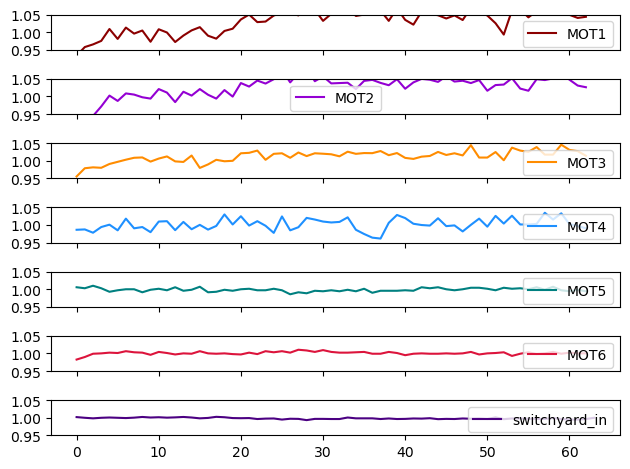

In [18]:
labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=7,sharex=True)
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for ax,label,data,color in zip(axes,labels,MOTdata,colors):
    xpts = list(range(len(data)-1))
    ax.plot(xpts, data[1:], label=label, color=color)
    ax.set_ylim((0.95,1.05))
    ax.legend()
fig.tight_layout()

## 2023.08.25

In [3]:
# MOT feedback and monitoring which I ran this morning
f = h5py.File(os.path.join(results, '2023-08-25\\09\\000004371-AOMsCoils.h5'))

In [ ]:
list(f.keys())

In [56]:
f['datasets'].keys()

<KeysViewHDF5 ['MOT1_monitor', 'MOT2_monitor', 'MOT3_monitor', 'MOT4_monitor', 'MOT5_monitor', 'MOT6_monitor', 'MOT_switchyard_monitor', 'monitor_pts']>

In [57]:
[MOT1,MOT2,MOT3,MOT4,MOT5,MOT6,MOTswyd,_] = f['datasets'].values()

In [58]:
MOT3.shape

(113,)

In [59]:
MOTdata = [MOT1,MOT2,MOT3,MOT4,MOT5,MOT6,MOTswyd,_] = f['datasets'].values()
MOT1.shape

(113,)

In [60]:
MOTdata = [np.array(data) for data in  f['datasets'].values()][:7]

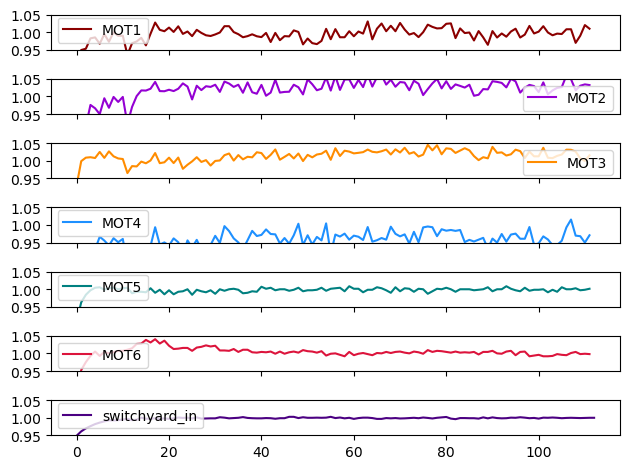

In [62]:
labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=7,sharex=True)
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for ax,label,data,color in zip(axes,labels,MOTdata,colors):
    xpts = list(range(len(data)-1))
    ax.plot(xpts, data[1:], label=label, color=color)
    ax.set_ylim((0.95,1.05))
    ax.legend()
fig.tight_layout()

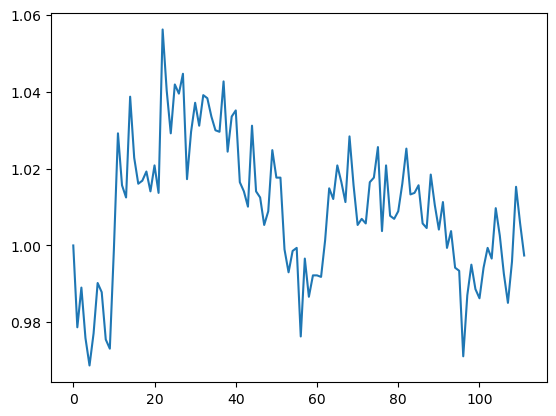

In [41]:
plt.plot(np.array(MOT1))

In [29]:
MOTdata

ValuesViewHDF5(<HDF5 group "/datasets" (8 members)>)